### Automated Fatal Encounter Modeler

Once you run all the following code and answer the prompts some plot depicting areas of interest will be shown and an html graph of the actual and future predicted fatal encounters will be downloaded. The code will also download 3 CSV files, one of a count of Actual fatal encounters up to the most current date on file, one of predicted count of fatal encounters, and one containing all of the data we have on the fatal encounters that occured in the area you requested a report for including names, dates, a brief description of the incident, and more.

For the sake of demonstrating how it works, I'll upload this note along with the files generated from requesting a fatal encounter report of California.

In [1]:
# Import Library dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
from fbprophet import Prophet
from scipy.stats import normaltest
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timedelta
from urllib.parse import quote
import plotly.graph_objs as go
import holidays
import random
import time

In [2]:
# Importing Dataset
gsheetid = r'1dKmaV_JiWcG8XBoRgP8b4e9Eopkpgt7FL7nyspvzAsE'
sheet_name = quote('Form Responses', safe='')
gsheet_url = r"https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(gsheetid, sheet_name)
df = pd.read_csv(gsheet_url)

C:\Users\latee\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,20,21,22,23,24,35,37,38,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Transforming Dataset
    #  Casting columns in lowercase
df.columns = map(lambda x: x.lower(), df.columns)

# Casting new column names
df = df.rename(columns={"subject's race":"race", 'location of death (city)' : 'city',
                        'location of death (county)' : 'county', 'location of death (zip code)':'zipcode',
                        "date of injury resulting in death (month/day/year)":"date"})

# Filling in missing data points in observations with values that doesn't obscure data
df = df.fillna(value={'race':'unspecified', 'location of death (city)':'unspecified',
                      'location of death (county)':'unspecified'})
# Dataframe used for final report 
df2 = df.drop(['unnamed: 30', 'unnamed: 31', 'unique id formula',
               'unique identifier (redundant)', 'unnamed: 34', 'unnamed: 35',
               'unnamed: 36', 'unnamed: 37', 'unnamed: 38', 'unnamed: 39',
               'unnamed: 40', 'unnamed: 41', 'unnamed: 42', 'unnamed: 43'], axis=1)

In [4]:
# Creating National Time Series Dataframe 
ld = list(df.date)
ld1 = pd.to_datetime(ld)
ld2 = pd.Series(ld1.to_period('d'))
ts = ld2.value_counts().sort_index().reset_index()
ts.columns = ['date', 'count']
ts.date = ts.date.dt.strftime('%m-%d-%Y')
ts.index = pd.to_datetime(ts.date)
tss = ts.drop('date', axis=1)
# This had to be a added to drop the invalid date they have in their google sheet as a spacer
tsss = tss[:-1]
all_dates = pd.date_range(start='2000/01/01', end=tsss.index.max(), freq='D')
national = tsss.reindex(all_dates, fill_value=0)

In [5]:
# Function that takes a Dataframe and a column header to create a new dataframe based on column headers unique value counts
    # Remember the global variable all_dates = pd.date_range(start='2000/01/01', end="last date in national dataframe", freq='D')
def output_ts_dict(df, column_header):
    # Check if column header is in df
        # If so, append every unique value of that Series to the list "unique_values"
    unique_values = []
    if column_header in df:
        unique_values.append(df[column_header].unique())
    else:
        return print('Column header not found')
    
    # Create a DataFrame of Series's containing a boolean mask for each item in unique_values
    masks = pd.DataFrame()
    for items in unique_values:
        for item in items:
            masks[item] = df[column_header] == item
    
    # Create a Dictionary of DataFrames one for each Series in the DataFrame masks
    dict_dfs = {}
    for columns in masks.columns:
        dict_dfs[columns] = df[masks[columns]]
    
    # Create a Dicitonary that stores the info needed for the TimeSeries-DataFrame
    dict_dfs001 = {}
    for item in dict_dfs.keys():
        dict_dfs001[item] = dict_dfs[item]['date']
    
    # Creating a Dictionary to hold TimeSeries-DataFrames and Performing Transformations that make them easy to use out of the Function
    dict_dfs002 = {}
    for count, key in enumerate(dict_dfs001):
        lister = list(dict_dfs001[key])
        date_lister = pd.to_datetime(lister)
        series_lister = pd.Series(date_lister.to_period('d'))
        time_series = series_lister.value_counts().sort_index().reset_index()
        time_series.columns = ['date', 'count']
        time_series.date = time_series.date.dt.strftime('%m-%d-%Y')
        time_series.index = pd.to_datetime(time_series.date)
        key_add = time_series.drop('date', axis=1)
        dict_dfs002[key] = key_add
        dict_dfs002[key] = dict_dfs002[key].reindex(all_dates, fill_value=0)
    return dict_dfs002

In [6]:
# Function to test stationarity of a dataset and return relevant information and a graph
def test_stationarity(timeseries, title):
    
    # Determining Rolling Statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    rolvar = timeseries.rolling(window=365).var()
    
    # Plot Rolling Statistics
    fig, ax = plt.subplots(figsize=(20,12))
    a = plt.plot(timeseries, color='blue', label='Original')
    a = plt.plot(rolmean, color='red', label='Rolling Mean')
    a = plt.plot(rolstd, color='black', label='Rolling STD')
    a = plt.plot(rolvar, color='orange', label='Rolling Variance')
    a = plt.legend(loc='best')
    ax.set_title(title, fontsize=15)
    plt.show(block=False)
    
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[:4], index=['Test Statistic', 'p-value', '#Lags Used',
                                            'Number of Oberservations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
# Function to display graphics for an overview of incidents
def display_ts_plots(df, response1):
    X, y = date_features(df, label='count')
    data = pd.concat([X, y], axis=1)
        
    # Total Count of Fatal Encouters
    fig, ax = plt.subplots(figsize=(20,12))
    yearaggregated = pd.DataFrame(data.groupby("year")["count"].sum()).reset_index()
    a = sns.barplot(data=yearaggregated, x="year", y="count")
    a.set_title("Total {} of Fatal Encounters per Year".format(response1), fontsize=15)
    
    # Display Plots
        # A bar plot represents an estimate of central tendency for a numeric variable with the height of each rectangle and 
        # Provides some indication of the uncertainty around that estimate using error bars.
    fig, ax = plt.subplots(figsize=(20,12))
    a = sns.barplot(x= "year", y= "count", hue = 'quarter', data = data)
    a.set_title("Central Tendency of {} Fatal Encounters by Year per Quarter of the Year".format(response1), fontsize=15)
    plt.legend(loc='best', prop={'size': 12})
    
    fig, ax = plt.subplots(figsize=(20,12))
    a = sns.barplot(x= "year", y= "count", hue = 'dayofweek', data = data)
    a.set_title("Central Tendency of {} of Fatal Encounters by Year per Day of the Week".format(response1), fontsize=15)
    plt.legend(loc='best', prop={'size': 12})
    plt.show()

In [8]:
# Function to create dataframe that breaks up the different aspects of dates of fatal encounters out into columns
def date_features(df, label=None):
    df = df.copy()
    
    df['date'] = df.index
    df['month'] = df['date'].dt.strftime('%B')
    df['year'] = df['date'].dt.strftime('%Y')
    df['dayofweek'] = df['date'].dt.strftime("%A")
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [9]:
def sci_plots(df, response1, s_plots):  
    stat, p_ = normaltest(df)
    
    if s_plots == 'yes':
        # Plotting histogram of orginal dataset
        fig, ax = plt.subplots(figsize=(20,12))
        a = sns.histplot(data=df, x="count")
        a.set_title("Histogram of Fatal Encounters Since Jan 1, 2000 Orginal Dataset", fontsize=15)
        print('\n'*2)
        print('Test Statistic of {} Normal Test'.format(response1), stat)
        print('p_value of {} Normal Test'.format(response1), p_)
        print('\n'*2)
        test_stationarity(df, response1)
        print()    
    else:
        pass
    
    return

In [10]:
# Function for model training, selection, predictions, plotting components, 
def df_auto_modeling(model_df, last_date, start_date, X_train, X_test, response1):
    
    # Maybe augment the grid
    params_grid = {'seasonality_mode': ('multiplicative','additive'),
                   'changepoint_prior_scale': [0.001, 0.01, 0.1],
                   'changepoint_range': [0.8, 0.9],
                   'seasonality_prior_scale': [0.001, 0.01,],
                   'holidays_prior_scale': [0.1, 0.3, 0.5]}
    grid = ParameterGrid(params_grid)
    
    t0 = time.time()
    model_parameters = pd.DataFrame(columns = ['MAE', 'Parameters'])
    count = 0
    for p in grid:
        test = pd.DataFrame()
        print(p)
        random.seed(0)
        train_model = Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                              seasonality_mode = p['seasonality_mode'],
                              seasonality_prior_scale = p['seasonality_prior_scale'],
                              changepoint_range = p['changepoint_range'],
                              holidays_prior_scale = p['holidays_prior_scale'])
        train_model.add_country_holidays(country_name = 'US')
        train_model.fit(X_train)
        train_forecast = train_model.make_future_dataframe(periods=121, freq='D', include_history=False)
        train_forecast = train_model.predict(train_forecast)
        test = train_forecast[['ds', 'yhat']]
        Actual = model_df[(model_df['ds']>start_date) & (model_df['ds']<=last_date)]
        MAE = round(mae(Actual['y'],test['yhat']), 6)
        count += 1
        print('model number :', count, 'MAE :', MAE)
        print('-'*100)
        model_parameters = model_parameters.append({'MAE':MAE, 'Parameters' :p}, ignore_index=True)
    t1 = time.time()
    total = t1-t0
    print("Model Training took: ", total, 'seconds')
    
    # Best Parameters are being selected and being ran again one last time for te final model
    parameters = model_parameters.sort_values(by=['MAE'])
    parameters = parameters.reset_index(drop=True)
    print(parameters['Parameters'][0])
    params = parameters['Parameters'][0]
    final_model = Prophet(**params, daily_seasonality=False)
    final_model.add_country_holidays(country_name='US')
    final_model.fit(X_train)
    future = final_model.make_future_dataframe(periods=171, freq='D')
    forecast = final_model.predict(future)
    
    # Plot the components of the model
    fig = final_model.plot_components(forecast)
    
    # This index is use for the plot and we'd like to see dates
    forecast.index = forecast['ds']
    forecast.tail(-171).to_csv('{} Fatal Encounters Prediction.csv'.format(response1))
    model_df.to_csv('{} Fatal Encounters Actual Count.csv'.format(response1))
        
    # Plot of Actual Fatal Encounters, Prediction from the model, Lower, and Upper yhat predictions
    fig = go.Figure([
        go.Scatter(
            name='Prediction',
            x=forecast.index[-182:],
            y=forecast.iloc[-182:,-1],
            mode='lines',
            line=dict(color='rgb(255, 140, 0)'),
        ),
        go.Scatter(
            name='Upper Bound',
            x=forecast.index[-182:],
            y=forecast.iloc[-182:,3],
            mode='lines',
            marker=dict(color="#444"),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='Lower Bound',
            x=forecast.index[-182:],
            y=forecast.iloc[-182:,2],
            marker=dict(color="#444"),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)',
            fill='tonexty',
            showlegend=False
        ),
        go.Scatter(
            name='Actual',
            x=forecast.index,
            y=model_df['y'],
            mode='lines',
            line=dict(color='rgb(31, 119, 180)'),
        )])

    fig.update_layout(
        yaxis_title='Count of Fatal Encounters',
        title='Fatal Encounters',
        hovermode="x")

    fig.update_xaxes(rangeslider_visible=True)
    fig.write_html('{}.html'.format(response1), auto_open=True)
    return

In [11]:
def df_train_test_split(df, s_plots):
    X, y = date_features(df, label='count')
    df_con = pd.concat([X, y], axis=1)
    model_df = pd.DataFrame({'ds' : df_con.index, 'y' : df_con['count']})
    last_date = df.index.max()
    start_date = last_date - timedelta(days=121)
    mask1 = ((model_df['ds']<start_date) & (model_df['ds']<last_date))
    X_train = model_df.loc[mask1]
    X_test = model_df.loc[-mask1]
    
    if s_plots == 'yes':
        # plot to show how much of the data is used to train and how much is used to test
        pd.plotting.register_matplotlib_converters()
        f, ax = plt.subplots(figsize=(14,5))
        X_train.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
        X_test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
        plt.title('Fatal Encounter Amount Traning and Test data')
        plt.show()
    else:
        pass
    
    return model_df, last_date, start_date, X_train, X_test

In [12]:
def final_plot_wrapper(df, response1, s_plots):
    # Whether Scientific plots are shown are decided within the below functons
    
    if s_plots == 'yes':
        print('\n'*2)
        sci_plots(df, response1, s_plots)
        model_df, last_date, start_date, X_train, X_test = df_train_test_split(df, s_plots)
        df_auto_modeling(model_df, last_date, start_date, X_train, X_test, response1)
    
    elif s_plots == 'no':
        print()
        print()
        sci_plots(df, response1, s_plots)
        model_df, last_date, start_date, X_train, X_test = df_train_test_split(df, s_plots)
        df_auto_modeling(model_df, last_date, start_date, X_train, X_test, response1)
    
    else:
        print('Invalid Response: Would you like to scientific plots? Please respond by replying yes or no.')

In [13]:
def ask_inputs():
    
    response = input("Are you interested in the US National, State, City, County, or Zipcode report of Fatal Encounters?")
    response = response.lower().replace(" ", "")
    
    if response == 'usnational':
        print('Ok National Report, please wait while reports are being generated.')
        response1 = 'United States'
        display_ts_plots(national, response1)
        print("Scientific plots include a histogram, a stationarity test, and normal test results.")
        s_plots = input('Would you like to see the scientific plots of the {} fatal encounters dataset before moving forward? Please Respond Yes or No.'.format(response1)).lower().replace(" ", "")
        final_plot_wrapper(national, response1, s_plots)
        print('Spreadsheet of all national cases')
        df2.to_csv('Fatal Encounters of US National in Report.csv')
    
        
    # If state is selected 
    elif response == 'state':
        print('Ok State Report, please wait while reports are being generated.')
        states = output_ts_dict(df, 'state')
        def state_option(states):
            response1 = input('Which state are you interested in receiving a report about?')
            response1 = response1.upper()
            try:
                display_ts_plots(states[response1], response1)
                print("Scientific plots include a histogram, a stationarity test, and normal test results.")
                s_plots = input('Would you like to see the scientific plots of the {} fatal encounters dataset before moving forward? Please Respond Yes or No.'.format(response1)).lower().replace(" ", "")
                final_plot_wrapper(states[response1], response1, s_plots)
                df2[df2[response] == response1].to_csv('Fatal Encounters of {} in Report.csv'.format(response1))
            
            except KeyError:
                print('Invalid Response: Please Enter a valid state.')
                state_option(states)
        state_option(states)
    
    elif response == 'city':
        print('Ok City Report, please wait while reports are being generated.')
        cities = output_ts_dict(df, 'city')
        def city_option(cities):
            response1 = input('Which city are you interested in receiving a report about?')
            response1 = response1.title()
            try:
                display_ts_plots(cities[response1], response1)
                print("Scientific plots include a histogram, a stationarity test, and normal test results.")
                s_plots = input('Would you like to see the scientific plots of the {} fatal encounters dataset before moving forward? Please Respond Yes or No.'.format(response1)).lower().replace(" ", "")
                final_plot_wrapper(cities[response1], response1, s_plots)
                df2[df2[response] == response1].to_csv('Fatal Encounters of {} in Report.csv'.format(response1))
            
            except KeyError:
                print("Sorry, unfortunately I couldn't find that {} not all {} are in the system.".format("city", "cities"))
                print("Please try another city")
                city_option(cities)
        city_option(cities)

    
    elif response == 'county':
        print('Ok County Report, please wait while reports are being generated.')
        counties = output_ts_dict(df, 'county')
        def county_option(counties):
            response1 = input('Which county are you interested in receiving a report about?')
            response1 = response1.title()
            try:
                display_ts_plots(counties[response1], response1)
                print("Scientific plots include a histogram, a stationarity test, and normal test results.")
                s_plots = input('Would you like to see the scientific plots of the {} fatal encounters dataset before moving forward? Please Respond Yes or No.'.format(response1)).lower().replace(" ", "")
                final_plot_wrapper(counties[response1], response1, s_plots)
                df2[df2[response] == response1].to_csv('Fatal Encounters of {} in Report.csv'.format(response1))
            
            except KeyError:
                print("Sorry, unfortunately I couldn't find that {} not all {} are in the system.".format("county", "counties"))
                print("Please try another county")
                county_option(counties)
        county_option(counties)
        
    
    elif response == 'zipcode':
        print('Ok Zipcode Report, please wait while reports are being generated.')
        zipcodes = output_ts_dict(df, 'zipcode')
        def zipcode_option(zipcodes):
            response1 = input('Which zipcode are you interested in receiving a report about?')
            response1 = float(response1)
            try:
                display_ts_plots(zipcodes[response1], response1)
                print("Scientific plots include a histogram, a stationarity test, and normal test results.")
                s_plots = input('Would you like to see the scientific plots of the {} fatal encounters dataset before moving forward? Please Respond Yes or No.'.format(response1)).lower().replace(" ", "")
                final_plot_wrapper(zipcodes[response1], response1, s_plots)
                df2[df2[response] == response1].to_csv('Fatal Encounters of {} in Report.csv'.format(response1))
            
            except KeyError:
                print("Sorry, unfortunately I couldn't find that {} not all {} are in the system.".format("zipcode", "zipcodes"))
                print("Please try another zipcode")
                zipcode_option(zipcodes)
        zipcode_option(zipcodes)
    
    else:
        print('The response options are US National, State, City, County, Zipcode?')
        ask_inputs()
        return
    return

Are you interested in the US National, State, City, County, or Zipcode report of Fatal Encounters? state


Ok State Report, please wait while reports are being generated.


Which state are you interested in receiving a report about? ca


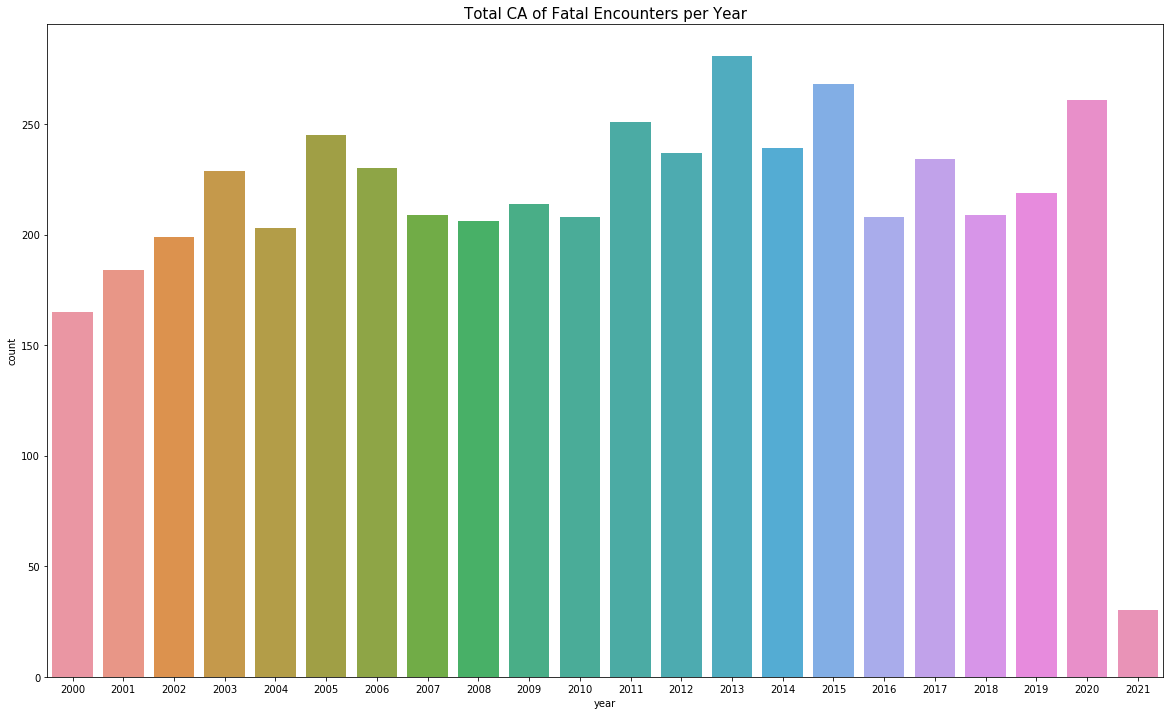

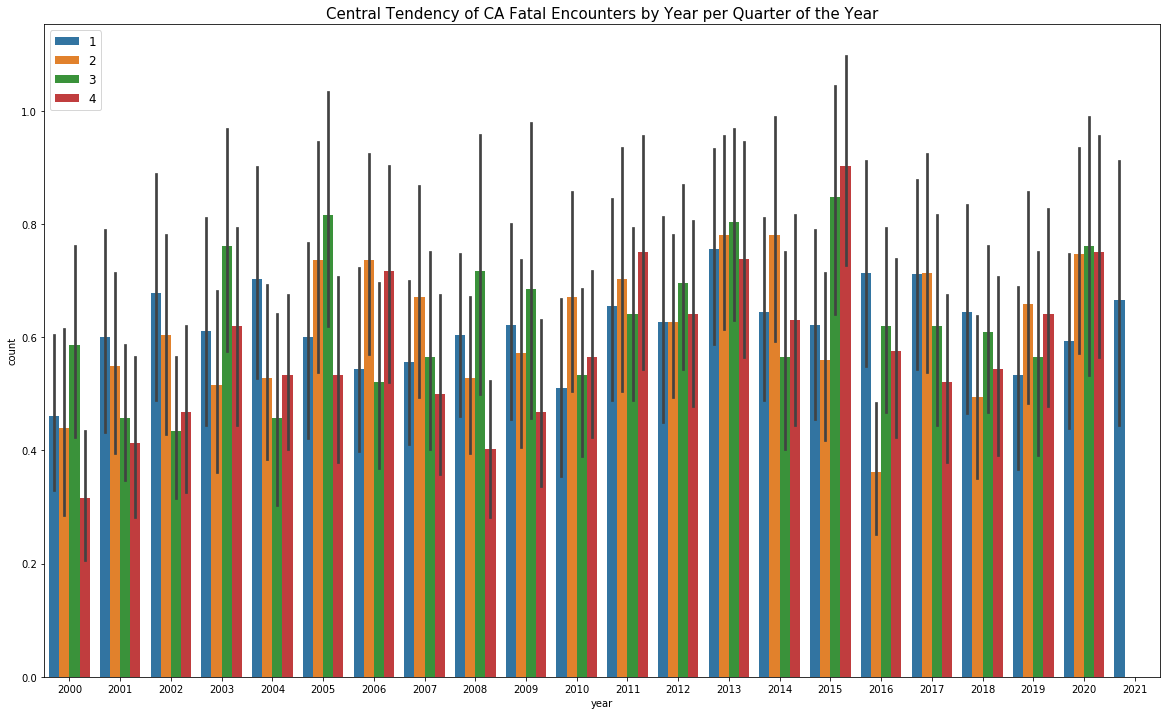

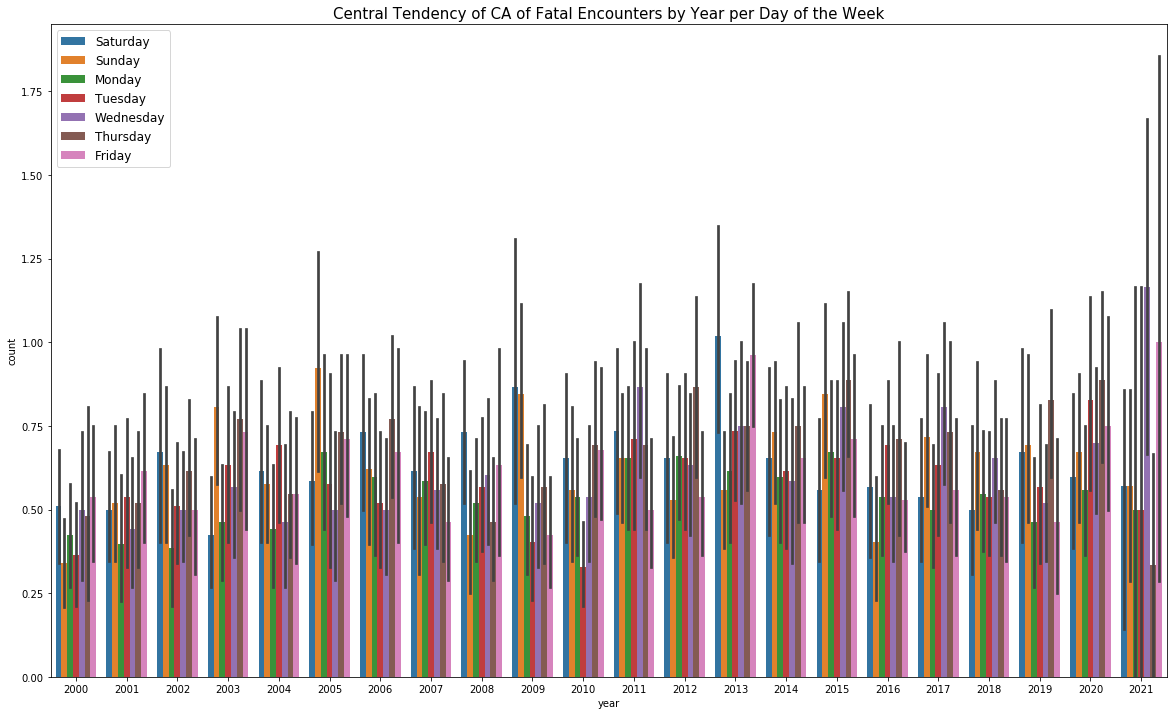

Scientific plots include a histogram, a stationarity test, and normal test results.


Would you like to see the scientific plots of the CA fatal encounters dataset before moving forward? Please Respond Yes or No. yes








Test Statistic of CA Normal Test [2786.72080003]
p_value of CA Normal Test [0.]





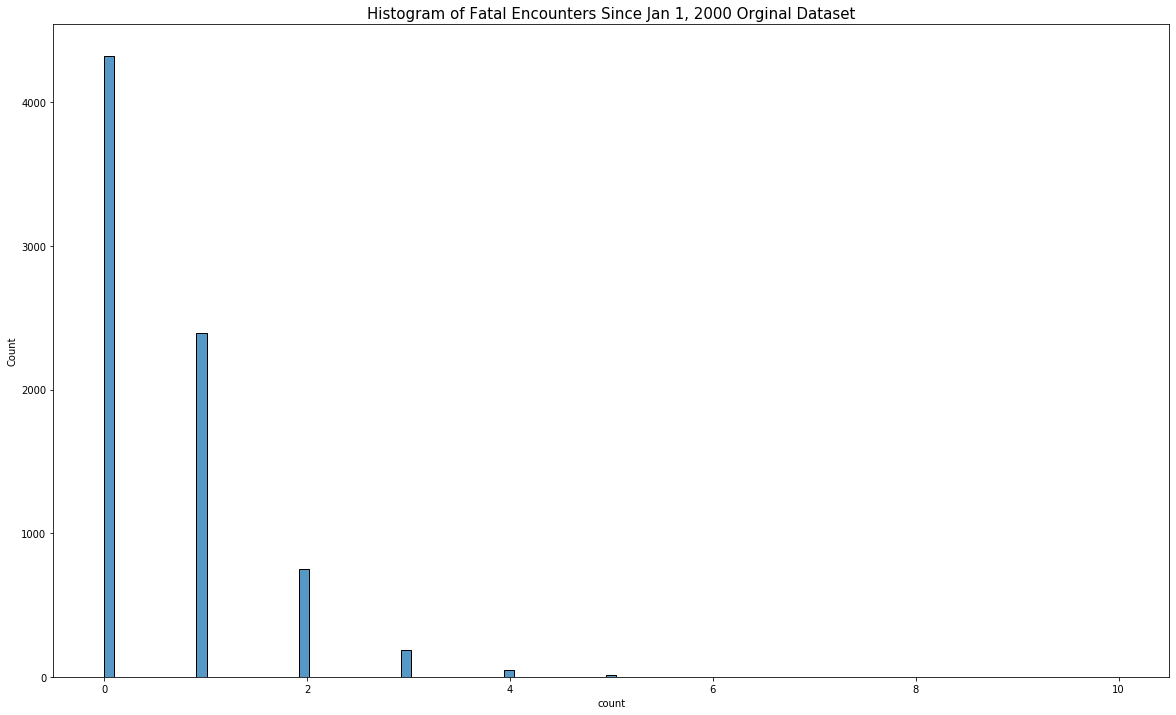

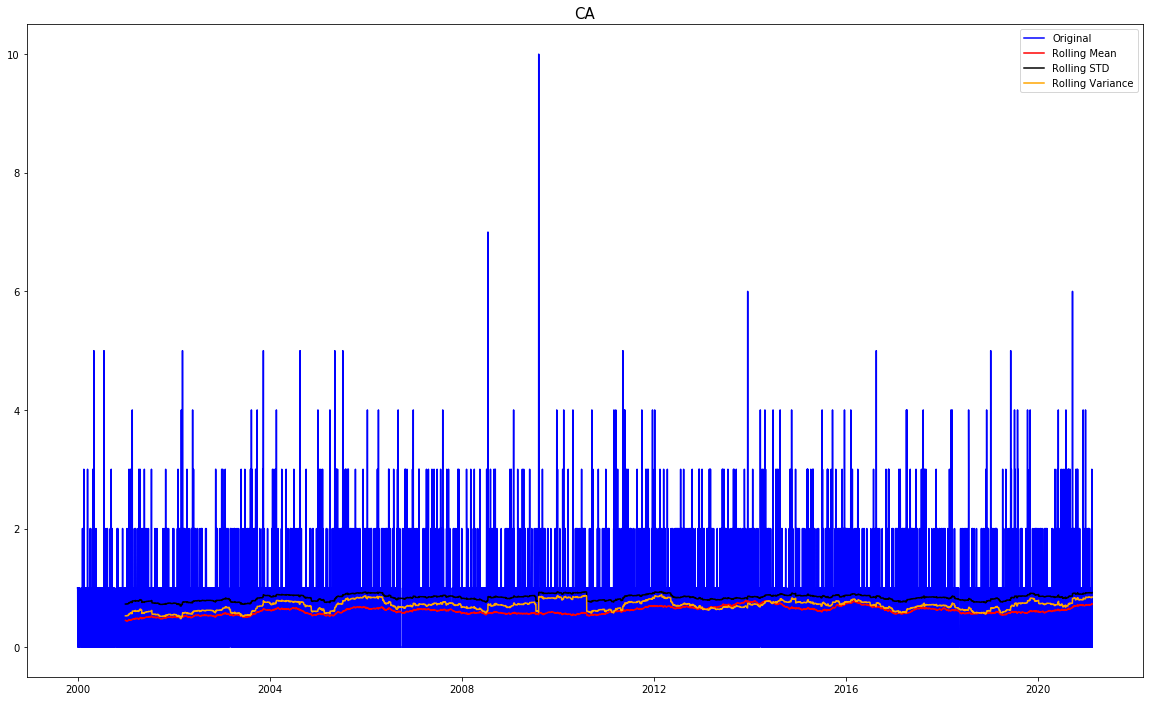

Results of Dickey-Fuller Test:
Test Statistic                    -28.750263
p-value                             0.000000
#Lags Used                          7.000000
Number of Oberservations Used    7708.000000
Critical Value (1%)                -3.431199
Critical Value (5%)                -2.861915
Critical Value (10%)               -2.566970
dtype: float64



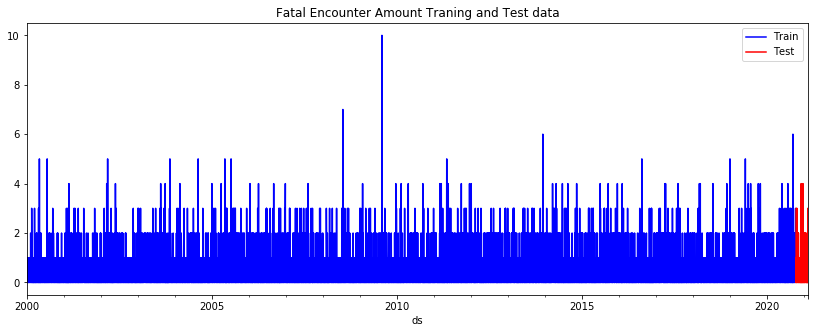

{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 1 MAE : 0.697702
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 2 MAE : 0.696808
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 3 MAE : 0.694449
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 4 MAE : 0.689573
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 5 MAE : 0.697694
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 6 MAE : 0.696705
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 7 MAE : 0.694423
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 8 MAE : 0.689706
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 9 MAE : 0.697694
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 10 MAE : 0.696712
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 11 MAE : 0.694429
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 12 MAE : 0.689659
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 13 MAE : 0.697516
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 14 MAE : 0.696776
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 15 MAE : 0.694801
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 16 MAE : 0.690891
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 17 MAE : 0.69755
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 18 MAE : 0.696767
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 19 MAE : 0.694438
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 20 MAE : 0.690526
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 21 MAE : 0.697638
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 22 MAE : 0.696914
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 23 MAE : 0.694467
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.001, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 24 MAE : 0.690743
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 25 MAE : 0.696362
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 26 MAE : 0.695364
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 27 MAE : 0.692189
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 28 MAE : 0.686316
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 29 MAE : 0.696384
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 30 MAE : 0.695322
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 31 MAE : 0.692519
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 32 MAE : 0.686532
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 33 MAE : 0.696419
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 34 MAE : 0.695216
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 35 MAE : 0.691395
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 36 MAE : 0.686424
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 37 MAE : 0.696469
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 38 MAE : 0.695402
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 39 MAE : 0.691899
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 40 MAE : 0.686071
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 41 MAE : 0.696543
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 42 MAE : 0.695334
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 43 MAE : 0.691917
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 44 MAE : 0.686701
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 45 MAE : 0.696563
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 46 MAE : 0.695245
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 47 MAE : 0.691343
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.01, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 48 MAE : 0.686869
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 49 MAE : 0.695618
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 50 MAE : 0.694601
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 51 MAE : 0.690701
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 52 MAE : 0.685566
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 53 MAE : 0.694804
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 54 MAE : 0.69398
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 55 MAE : 0.690942
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 56 MAE : 0.685677
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 57 MAE : 0.694565
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 58 MAE : 0.693162
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 59 MAE : 0.690741
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 60 MAE : 0.685582
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 61 MAE : 0.698059
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 62 MAE : 0.697162
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 63 MAE : 0.694268
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 64 MAE : 0.689002
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 65 MAE : 0.69771
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 66 MAE : 0.69656
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 67 MAE : 0.694941
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.3, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 68 MAE : 0.689265
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 69 MAE : 0.698113
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 70 MAE : 0.695876
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.001}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model number : 71 MAE : 0.694405
----------------------------------------------------------------------------------------------------
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.9, 'holidays_prior_scale': 0.5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}
model number : 72 MAE : 0.689398
----------------------------------------------------------------------------------------------------
Model Training took:  761.6176393032074 seconds
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.8, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


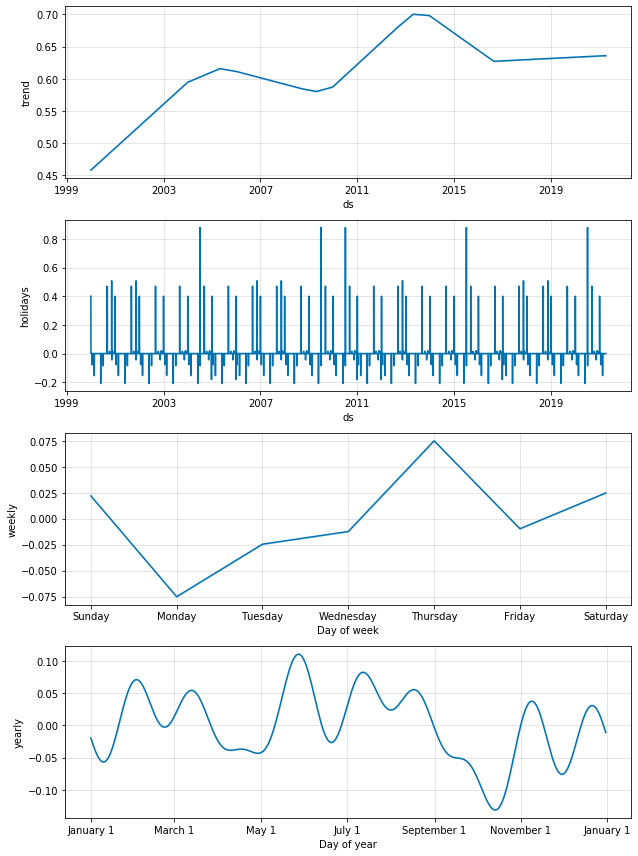

In [14]:
ask_inputs()